# IMPORTS

In [1]:
import csv
import os
import time
import datetime
import re
from utils import * 
# Data Analysis

import numpy as np
import pandas as pd

# Data Saving
import pickle
from pickle import dump
from pickle import load
from functools import partial

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
#from sklearn.metrics import confusion_matrix, roc_curve,auc, classification_report

import tensorflow as tf
# import tensorflow.keras.backend as K
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Embedding
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# from tensorflow.keras.utils import plot_model
print(f"Tensorflow Version: {tf.__version__}")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rajesharasada/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rajesharasada/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Tensorflow Version: 2.3.1


# LOAD DATA

In [2]:
# Read the data into a pandas dataframe
# Filepath
file_path = os.path.join("../data/raw", "amazon_baby.csv")

# Read and sample few observations
all_products = pd.read_csv(file_path)
all_products.sample(5)

,name,review,rating
45613,"Tiny Love Take-Along Arch, Sunny Stroll",My daughter needed something to keep her busy ...,5
174119,"Prince Lionheart Compact Wipes Warmer, Green",I like the warmer...small and warms the wipes ...,4
77658,Badger Basket Folding Nursery Basket/Storage C...,The basket is great and is the perfect size to...,5
85568,"Athena Daphne Convertible Crib and Changer, Wh...",I fell in love with the crib because it featur...,3
78970,Gerber Graduates BPA Free 2 Pack Fun Grips spi...,Truly leak proof!!!Only con is that they don't...,5


In [3]:
print(f"Number of Observations: {all_products.shape[0]}")
print(f"Number of Features: {all_products.shape[1]}")
print(f"Features: \n{all_products.columns.tolist()}")

Number of Observations: 183531
Number of Features: 3
Features: 
['name', 'review', 'rating']


## Target Feature - "Rating"

In [4]:
# Number of possible ratings
print(f"Number of unique review values: {all_products['rating'].nunique()}")

Number of unique review values: 5


5    107054
4     33205
3     16779
1     15183
2     11310
Name: rating, dtype: int64



Text(0, 0.5, 'number of reviews')

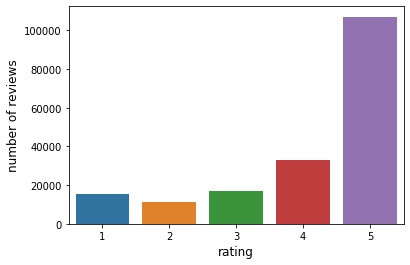

In [5]:
# Count number of reviews for each rating
print(all_products['rating'].value_counts())
print()
# Plot rating counts
sns.barplot(x=all_products['rating'].value_counts().index, y=all_products['rating'].value_counts())
plt.xlabel("rating", fontsize=12)
plt.ylabel("number of reviews", fontsize=12)

We will drop all neutral reviews i.e., reviews rated 3 and group reviews rated 1 and 2 as negative and reviews rated 4 and 5 as positive. 

In [6]:
print(f"Number of observations in raw dataset:{all_products.shape[0]}")

#  Drop reviews rated as 3
products = all_products.loc[all_products['rating']!=3, ['review', 'rating']]
print(f"Number of observations in the dataset after dropping neutral (3) reviews:{products.shape[0]}")

Number of observations in raw dataset:183531
Number of observations in the dataset after dropping neutral (3) reviews:166752


In [7]:
neutral_ratings = all_products.loc[all_products['rating']==3, ['review', 'rating']]
num_neutral_ratings = neutral_ratings.shape[0]
print(f"Number of reviews with neutral ratings: {num_neutral_ratings}")
assert all_products.shape[0]  == products.shape[0] + neutral_ratings.shape[0]

Number of reviews with neutral ratings: 16779


In [8]:
# Ratings above 3 as positive and below 3 as negative.
products['sentiment'] = products['rating'].apply(lambda x: 1 if x >3 else 0)
products[['rating', 'sentiment']].sample(10)

,rating,sentiment
3135,5,1
174865,5,1
139179,1,0
143819,2,0
86212,5,1
14741,1,0
141212,5,1
167281,5,1
109439,1,0
174217,5,1


Text(0.5, 0, 'Sentiment')

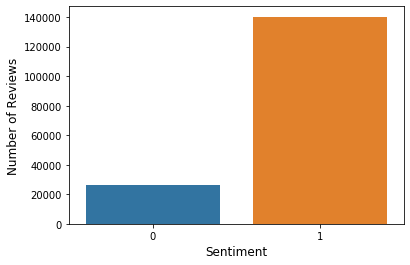

In [9]:
products['sentiment'].value_counts()
sns.barplot(products['sentiment'].value_counts().index, products['sentiment'].value_counts())
plt.ylabel("Number of Reviews", fontsize=12)
plt.xlabel("Sentiment", fontsize=12)

In [10]:
new_labels = tf.keras.utils.to_categorical(products['sentiment'], num_classes=2, dtype='float32')
print("labels:")
print(new_labels)

labels:
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


## Reviews

In [11]:
# Lowercase the token, remove NLTK english stopwords and include token that are longer than 1 character
products['review_clean'] = products['review'].apply(lambda x: clean_text(x))

In [12]:
products[['review','review_clean']].head(5)

,review,review_clean
1,it came early and was not disappointed. i love...,came early disappointed. love planet wise bags...
2,Very soft and comfortable and warmer than it l...,soft comfortable warmer looks...fit full size ...
3,This is a product well worth the purchase. I ...,product well worth purchase. found anything el...
4,All of my kids have cried non-stop when I trie...,"kids cried non-stop tried ween pacifier, found..."
5,"When the Binky Fairy came to our house, we did...","Binky Fairy came house, special gift book help..."


In [13]:
reviews, labels = products['review_clean'].values, products['sentiment'].values

In [14]:
reviews

array(['came early disappointed. love planet wise bags wipe holder. keps osocozy wipes moist leak. highly recommend it.',
       'soft comfortable warmer looks...fit full size bed perfectly...would recommend anyone looking type quilt',
       'product well worth purchase. found anything else like this, positive, ingenious approach losing binky. love product much ownership daughter getting rid binky. proud herself, loves little fairy. love artwork, chart back, clever approach tool.',
       ...,
       'item looks great cool kids....I know Company great quality...',
       'extremely happy product. searching product like long time found right one. mum organic products unllike many others looked at, Tutti Bimbi Freezer Tray also BPA phthalates free. bright packaging ability choose colour attracted listing fact prepare meals generous portion size baby one time massive advantage working mum. freeze tray easily comes easy clip lid also protects freezer burn. found also put baby food tray di

In [15]:
print("labels.txt : \t \t \t \t \t reviews.txt\n")
pretty_print(reviews, labels, 1)
pretty_print(reviews, labels, 11)
pretty_print(reviews, labels, 111)

labels.txt : 	 	 	 	 	 reviews.txt

Sentiment 1: 	 soft comfortable warmer looks...fit full size bed perfectly...would recommend anyone looking type qu
Sentiment 1: 	 originally gave nanny pad paper write information little one. would take park leave pad behind getti
Sentiment 0: 	 put yet disappointed color flowers. look purple pink.


In [16]:
if os.path.exists("../data/processed/reviews_clean.pkl"):
    print("File Exists")
else:
    save_dataset(reviews, "../data/processed/reviews_clean.pkl")

File Exists


In [17]:
num_pos_review = int(np.sum(new_labels, axis=0)[1])
num_neg_review = int(np.sum(new_labels, axis=0)[0])
total_num_reviews = len(reviews)

percent_pos_reviews = round(100* (num_pos_review/total_num_reviews),2)
percent_neg_reviews = round(100* (num_neg_review/total_num_reviews),2)

print(f"Total number of reviews in the dataset   : {len(reviews)}")
print(f"{num_pos_review} / {percent_pos_reviews}% Number of reviews with positive sentiment: {int(np.sum(new_labels, axis=0)[1])}")
print(f"{num_neg_review} / {percent_neg_reviews}% Number of reviews with negative sentiment: {int(np.sum(new_labels, axis=0)[0])}")

Total number of reviews in the dataset   : 166752
140259 / 84.11% Number of reviews with positive sentiment: 140259
26493 / 15.89% Number of reviews with negative sentiment: 26493


In [18]:
with open("../data/processed/reviews_clean.pkl", 'rb') as f:
    reviews = pickle.load(f)

reviews[:1]

array(['came early disappointed. love planet wise bags wipe holder. keps osocozy wipes moist leak. highly recommend it.'],
      dtype=object)

# Generate WordCloud

In [19]:
positive_reviews = " ".join(review for review in products[products['sentiment'] == 1]['review_clean'])
negative_reviews = " ".join(review for review in products[products['sentiment'] == 0]['review_clean'])

In [20]:
positive_wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000).generate(positive_reviews)
negative_wordcloud = WordCloud(background_color='white', mode="RGBA", max_words=1000).generate(negative_reviews)

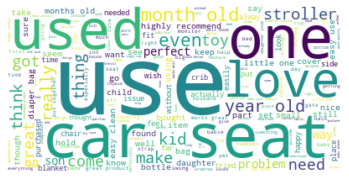

In [21]:
# Display the generated image:
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
# Save the image in the img folder:
positive_wordcloud.to_file("../figures/positive_reviews.png")

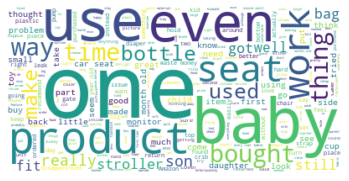

In [23]:
# Display the generated image:
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
# Save the image in the img folder:
negative_wordcloud.to_file("../figures/negative_reviews.png")

In [25]:
pos_freq, neg_freq = compute_class_freqs(new_labels)
pos_freq, neg_freq

(array([0.15887666, 0.84112334]), array([0.84112334, 0.15887666]))

In [26]:
pos_weights = neg_freq
neg_weights = pos_freq

pos_contribution = pos_freq * pos_weights 
neg_contribution = neg_freq * neg_weights

In [27]:
pos_weights, neg_weights

(array([0.84112334, 0.15887666]), array([0.15887666, 0.84112334]))

In [28]:
# Train Data
train_fraction = 0.8
train_sample = round(len(reviews) * train_fraction)

train_reviews = reviews[:train_sample]
train_labels = new_labels[:train_sample]

# Validation and Test data
test_valid_reviews = reviews[train_sample:]
test_valid_labels = new_labels[train_sample:]

valid_fraction = 0.5
valid_sample = round(len(test_valid_reviews) * valid_fraction)

valid_reviews = test_valid_reviews[: valid_sample]
valid_labels = test_valid_labels[: valid_sample]

test_reviews = test_valid_reviews[valid_sample:]
test_labels = test_valid_labels[valid_sample:]

In [29]:
if os.path.exists(os.path.join("../data/processed", "train.pkl")):
    print("File exists")
else:
    save_dataset([train_reviews, train_labels], "../data/processed/train.pkl")
    
if os.path.exists(os.path.join("../data/processed", "valid.pkl")):
    print("File exists")
else:
    save_dataset([valid_reviews, valid_labels], "../data/processed/valid.pkl")
    
if os.path.exists(os.path.join("../data/processed", "test.pkl")):
    print("File exists")
else:
    save_dataset([test_reviews, test_labels], "../data/processed/test.pkl")

File exists
File exists
File exists
